### Programming for Biomedical Informatics
#### Week 8 Assignment - Consensus Clustering

In this weekly mini assignment you will implement a simple consensus clustering approach to look at the robusteness of clusters between different clustering iterations.

I have provided an associated data file for the network as a .gml file that can be imported directly using networkx

**NetworkX - Network Analysis in Python - [https://networkx.org/documentation/stable/index.html](https://networkx.org/documentation/stable/index.html)**

In [23]:
# import libraries
# use networkx to import the graph 'gene_coexpression_network_pearson.gml'

import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
G = nx.read_gml('gene_coexpression_network_pearson.gml')

In [24]:
# Function to clean the graph
def clean_graph(G, degree_threshold=1, keep_largest_component=True):
    """
    Cleans the graph by performing several cleaning steps:
    - Removes unconnected nodes (isolates)
    - Removes self-loops
    - Removes nodes with a degree below a specified threshold
    - Keeps only the largest connected component (optional)

    Parameters:
    G (nx.Graph): The NetworkX graph to clean.
    degree_threshold (int): Minimum degree for nodes to keep.
    keep_largest_component (bool): Whether to keep only the largest connected component.

    Returns:
    G (nx.Graph): Cleaned graph.
    """
    G = G.copy()  # Work on a copy of the graph to avoid modifying the original graph

    # Remove self-loops
    G.remove_edges_from(nx.selfloop_edges(G))

    # Remove nodes with no edges (isolates)
    G.remove_nodes_from(list(nx.isolates(G)))

    # Remove nodes with degree below the threshold
    low_degree_nodes = [node for node, degree in dict(G.degree()).items() if degree < degree_threshold]
    G.remove_nodes_from(low_degree_nodes)

    # Keep only the largest connected component
    if keep_largest_component:
        largest_cc = max(nx.connected_components(G), key=len)
        G = G.subgraph(largest_cc).copy()

    return G

In [25]:
# create a pruned network
pruned_network = clean_graph(G, degree_threshold=1, keep_largest_component=True)

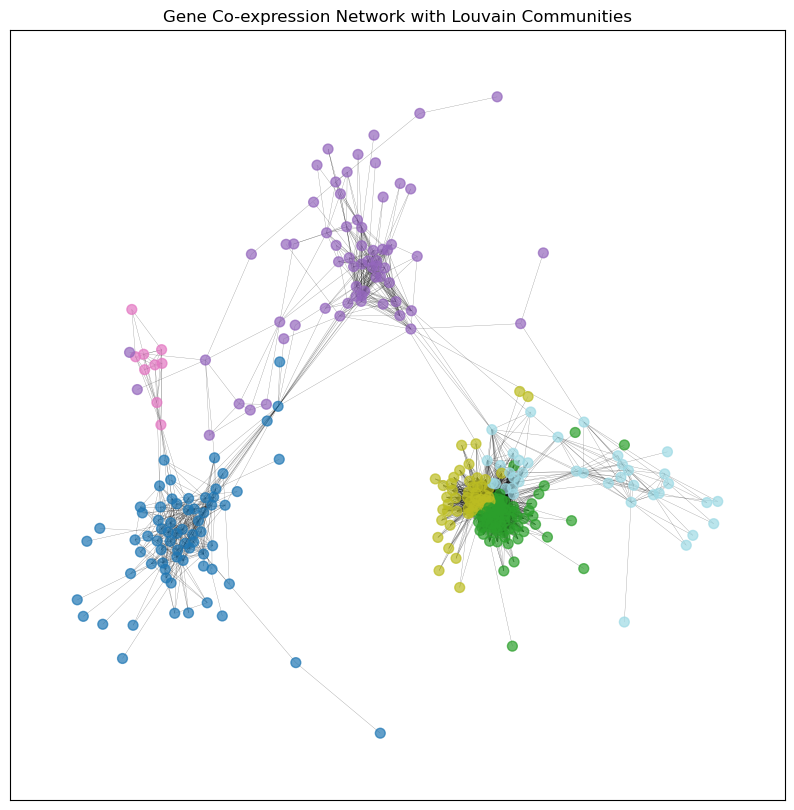

In [26]:
# use the networkx communtity detection algorithm 'louvain_communities' to detect communities in the network
clustering_result =  nx.algorithms.community.louvain_communities(pruned_network, resolution=1.0)

# Visualise the graph with nodes coloured by community
plt.figure(figsize=(10, 10))
pos = nx.spring_layout(pruned_network, k=0.1, seed=50)

# create a mapping between nodes and communities
node_community_map = {node: i for i, community in enumerate(clustering_result) for node in community}

# Draw nodes with community colours
node_colors = [node_community_map[node] for node in pruned_network.nodes()]

nx.draw_networkx_nodes(pruned_network, pos, node_size=50, node_color=node_colors, cmap='tab20', alpha=0.7)
nx.draw_networkx_edges(pruned_network, pos, width=0.2, alpha=0.5)

plt.title('Gene Co-expression Network with Louvain Communities')
plt.show()

In [27]:
# replace the node ids with a numeric value and keep a mapping between the two
# we need to do this because we're going to use the node ids as indices in a matrix
node_mapping = {node: i for i, node in enumerate(pruned_network.nodes())}

# replace the node ids in the graph ready for the next step
pruned_network = nx.relabel_nodes(pruned_network, node_mapping)

In [28]:
# define a function to create a co_occurrence matrix where the rows and columns are the nodes
# and the values of the entry for each pair of nodes is 1 if they are in the same community
# and 0 if they are not
# the function will take the graph and a clustering result as input and return the co-occurrence matrix
def create_co_occurrence_matrix(graph, clustering_result):
    n = len(pruned_network.nodes())
    co_matrix = np.zeros((n, n))

    # fill the matrix with 1s where nodes are in the same community
    for i, community in enumerate(clustering_result):
        for node1 in community:
            for node2 in community:
                co_matrix[node1][node2] = 1
    return co_matrix

In [29]:
# call louvain clustering 10 times but with increasing 'levels' from 1 to 1000 in steps of 100
# this alters the stopping criterion for the algorithm
# calculate the average co-occurrence matrix over the 10 runs

# initialise the matrix
n = len(pruned_network.nodes())
co_matrix = np.zeros((n, n))

for level in range(1,1000,100):
    clustering_result = nx.algorithms.community.louvain_communities(pruned_network, resolution=1.0, weight='weight', max_level=level)
    co_matrix += create_co_occurrence_matrix(pruned_network, clustering_result)

# normalise the matrix
co_matrix = co_matrix / 10

In [30]:
# convert the matrix to a graph only keeping edges with normalised co-occurrence above 0.90
G_co_occurrence = nx.Graph()

for i in range(n):
    for j in range(n):
        if co_matrix[i][j] > 0.90:
            G_co_occurrence.add_edge(i, j, weight=co_matrix[i][j])

# remove self loops
G_co_occurrence.remove_edges_from(nx.selfloop_edges(G_co_occurrence))

# remove unconnected nodes
G_co_occurrence.remove_nodes_from(list(nx.isolates(G_co_occurrence)))

13
[72, 64, 52, 48, 22, 16, 9, 9, 4, 3, 2, 2, 2]


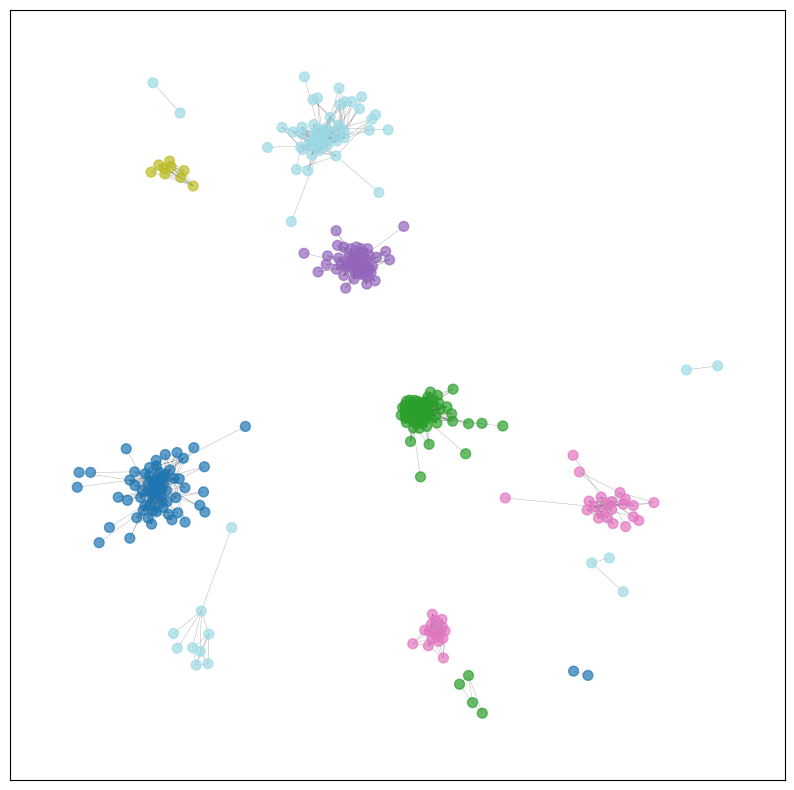

In [ ]:
# now alter our existing pruned_network to only retain edges that are in commmon with the co-occurrence network
pruned_network = pruned_network.edge_subgraph(G_co_occurrence.edges())

# how many connected components does this graph have?
print(nx.number_connected_components(pruned_network))

# print the size of each connected component ordered by size
print(sorted([len(c) for c in nx.connected_components(pruned_network)], reverse=True))

# Visualise the graph with nodes coloured by community where the communities are those detected above that produced
# the 'clustering_result' object
plt.figure(figsize=(10, 10))
pos = nx.spring_layout(pruned_network, k=0.1, seed=50)

# create a mapping between nodes and communities
node_community_map = {node: i for i, community in enumerate(clustering_result) for node in community}

# Draw nodes with community colours
node_colors = [node_community_map[node] for node in pruned_network.nodes()]
nx.draw_networkx_nodes(pruned_network, pos, node_size=50, node_color=node_colors, cmap='tab20', alpha=0.7)
nx.draw_networkx_edges(pruned_network, pos, width=0.2, alpha=0.5);

# what do you notice about the communities in this graph?